In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
df=pd.read_csv('updated.csv')
print("Max :",np.max(df['time_elapsed'].value_counts()))
print("Min :",np.min(df['time_elapsed'].value_counts))

Max : 59
Min : <bound method IndexOpsMixin.value_counts of 0            0
1            1
2            2
3            4
4            5
          ... 
104404    6142
104405    6142
104406    6142
104407    6142
104408    6142
Name: time_elapsed, Length: 104409, dtype: int64>


In [68]:
df.columns

Index(['year', 'month', 'day', 'latitude', 'longitude', 'zon.winds',
       'mer.winds', 'humidity', 'air temp.', 's.s.temp.', 'time_elapsed'],
      dtype='object')

In [69]:
corr=df.corr()
corr['s.s.temp.']

year            0.219676
month          -0.098703
day            -0.003908
latitude        0.127508
longitude       0.425969
zon.winds       0.302566
mer.winds      -0.291506
humidity       -0.406883
air temp.       0.896051
s.s.temp.       1.000000
time_elapsed    0.209926
Name: s.s.temp., dtype: float64

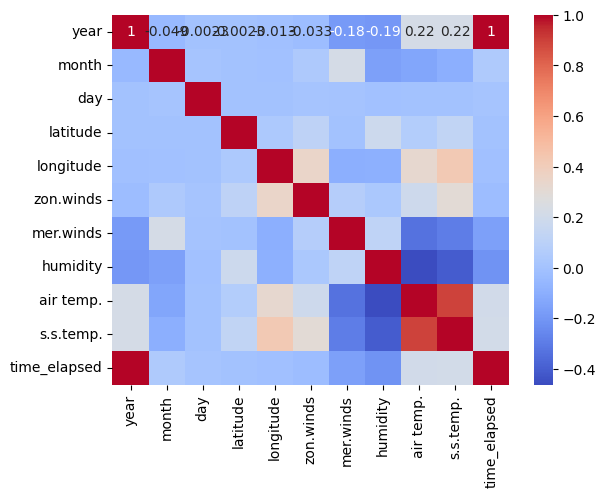

In [70]:
sns.heatmap(corr,cmap='coolwarm',annot=True)
plt.show()

In [71]:
X_train=df[df['time_elapsed']<=5100].drop(columns=['s.s.temp.'])
X_test=df[df['time_elapsed']>5100].drop(columns=['s.s.temp.'])
#X_train.drop(columns=['day'],inplace=True)
#X_test.drop(columns=['day'],inplace=True)

y_train=df[df['time_elapsed']<=5100]['s.s.temp.']
y_test=df[df['time_elapsed']>5100]['s.s.temp.']

In [72]:
# Tranformers

from sklearn.preprocessing import FunctionTransformer,StandardScaler,PowerTransformer

yeojohnson_transformer=PowerTransformer(method='yeo-johnson')
X_train['zon.winds']=yeojohnson_transformer.fit_transform(X_train[['zon.winds']])
X_test['zon.winds']=yeojohnson_transformer.transform(X_test[['zon.winds']])

''log_tranformer=FunctionTransformer(np.log1p,validate=True)
X_train['air temp.']=log_tranformer.fit_transform(X_train[['air temp.']])
X_test['air temp.']=log_tranformer.transform(X_test[['air temp.']])''

X_train['air temp.']=yeojohnson_transformer.fit_transform(X_train[['air temp.']])
X_test['air temp.']=yeojohnson_transformer.transform(X_test[['air temp.']])

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

"# Tranformers\n\nfrom sklearn.preprocessing import FunctionTransformer,StandardScaler,PowerTransformer\n\nyeojohnson_transformer=PowerTransformer(method='yeo-johnson')\nX_train['zon.winds']=yeojohnson_transformer.fit_transform(X_train[['zon.winds']])\nX_test['zon.winds']=yeojohnson_transformer.transform(X_test[['zon.winds']])\n\n''log_tranformer=FunctionTransformer(np.log1p,validate=True)\nX_train['air temp.']=log_tranformer.fit_transform(X_train[['air temp.']])\nX_test['air temp.']=log_tranformer.transform(X_test[['air temp.']])''\n\nX_train['air temp.']=yeojohnson_transformer.fit_transform(X_train[['air temp.']])\nX_test['air temp.']=yeojohnson_transformer.transform(X_test[['air temp.']])\n\nscaler=StandardScaler()\nX_train_scaled=scaler.fit_transform(X_train)\nX_test_scaled=scaler.transform(X_test)"

In [73]:
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error

xgb_param_grid={
    'learning_rate':[0.01,0.05,0.1],
    'max_depth':[2,3,4],
    'n_estimators':[230,250,270]
}
xgb_model=XGBRegressor()
xgb_grid_search=GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
xgb_grid_search.fit(X_train,y_train)
xgb_best_params=xgb_grid_search.best_params_
xgb_best_model=XGBRegressor(**xgb_best_params)
xgb_best_model.fit(X_train,y_train)

# Compute training error
y_train_pred_xgb = xgb_best_model.predict(X_train)
mse_xgb_train = mean_squared_error(y_train, y_train_pred_xgb)
r_2_xgb_train = r2_score(y_train, y_train_pred_xgb)

# Compute test error
y_pred_xgb = xgb_best_model.predict(X_test)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
r_2_xgb_test = r2_score(y_test, y_pred_xgb)

# Print results
print(f"Training MSE: {mse_xgb_train}")
print(f"Training R² Score: {r_2_xgb_train}")
print(f"Test MSE: {mse_xgb_test}")
print(f"Test R² Score: {r_2_xgb_test}")
print(f"XGBoost best params: {xgb_best_params}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training MSE: 0.22102451523225147
Training R² Score: 0.9534228639391943
Test MSE: 0.35304154732987864
Test R² Score: 0.9235284772989785
XGBoost best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 230}


In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the parameter grid for more regularization
rf_param_grid = {
    'n_estimators': [100, 200, 250, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6, 8]
}

# Create a pipeline with scaling and the RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('rf', RandomForestRegressor())
])

# GridSearch with cross-validation
rf_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid={
        'rf__n_estimators': rf_param_grid['n_estimators'],
        'rf__max_depth': rf_param_grid['max_depth'],
        'rf__min_samples_split': rf_param_grid['min_samples_split'],
        'rf__min_samples_leaf': rf_param_grid['min_samples_leaf']
    },
    verbose=1,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)
rf_best_params = rf_grid_search.best_params_
rf_best_model = rf_grid_search.best_estimator_
rf_best_model.fit(X_train, y_train)

# Predictions and performance metrics
y_pred_rf = rf_best_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_2_rf = r2_score(y_test, y_pred_rf)

# Compute training error
y_train_pred_rf = rf_best_model.predict(X_train)
mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
r_2_rf_train = r2_score(y_train, y_train_pred_rf)

# Cross-validated MSE
cross_val_scores = cross_val_score(rf_best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cross_val_mse = -cross_val_scores.mean()

# Print results
print(f"Training MSE: {mse_rf_train}")
print(f"Training R² Score: {r_2_rf_train}")
print(f"Test MSE: {mse_rf}")
print(f"Test R² Score: {r_2_rf}")
print(f"Random Forest best params: {rf_best_params}")
print(f"Cross-validated MSE: {cross_val_mse}")

# Check for overfitting
if mse_rf_train < mse_rf:
    print("Warning: The model might be overfitting. Training error is significantly lower than test error.")
else:
    print("The model does not appear to be overfitting.")


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Training MSE: 0.06372528821555892
Training R² Score: 0.9865709855008109
Test MSE: 0.32085926779425955
Test R² Score: 0.9304994073175328
Random Forest best params: {'rf__max_depth': 20, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 5, 'rf__n_estimators': 250}
Cross-validated MSE: 0.5232896831989173


In [75]:
comparison = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_rf})
comparison.tail(15)

,y_test,y_pred
104394,23.50,21.530508
104395,25.89,25.944599
104396,29.72,29.551992
104397,26.53,26.799458
104398,30.28,29.356375
104399,23.70,26.408894
104400,29.70,29.650365
104401,24.20,23.214316
104402,28.45,29.502154
104403,29.83,29.768213
